In [ ]:
import numpy as np

import torch
from torch import nn
from torch.nn import functional as F
from torch import optim

from torchvision import models, transforms

import time
import math
import random

from torch.utils.data import TensorDataset, DataLoader, Dataset
from sklearn.metrics import accuracy_score

import seaborn as sns
from matplotlib import colors, pyplot as plt
from matplotlib import rcParams
from IPython.display import clear_output

from tqdm import tqdm

%matplotlib inline
rcParams['figure.figsize'] = (15,4)
sns.set(style="darkgrid", font_scale=1.4)

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

GPU = torch.device('cuda:0')
CPU = torch.device('cpu')

In [ ]:
SEED = 42

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True

In [ ]:
!pip install gputil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for gputil: filename=GPUtil-1.4.0-py3-none-any.whl size=7411 sha256=b96b88bda5a2a6487e5daf1655cab1f50de28bd2c711f20135b027fb882a366e
  Stored in directory: /root/.cache/pip/wheels/6e/f8/83/534c52482d6da64622ddbf72cd93c35d2ef2881b78fd08ff0c
Successfully built gputil


In [ ]:
import GPUtil
import gc

In [ ]:
torch.cuda.empty_cache()
gc.collect()
GPUtil.showUtilization()

| ID | GPU | MEM |
------------------
|  0 |  0% |  0% |


In [ ]:
#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [ ]:
!nvidia-smi
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

Thu Jun  9 16:08:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Load dataset

## Way 1. By public link from google drive

In [ ]:
!pip install googledrivedownloader

In [ ]:
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1yqxfvTutEGOFMct5U_zVIP6e9v7R3AcL',
                                    dest_path='./segmentation.zip',
                                    unzip=True)

Unzipping...Done.


The archive will be unzipped

## Way 2. By direct link

https://www.dropbox.com/s/j5j1kd4h55x4pmp/segmentation.zip?dl=0
или
http://mlr.vedyakov.com/segmentation.zip

In [ ]:
!wget -c http://mlr.vedyakov.com/segmentation.zip

--2022-06-09 13:37:07--  http://mlr.vedyakov.com/segmentation.zip
Resolving mlr.vedyakov.com (mlr.vedyakov.com)... 77.234.215.110
Connecting to mlr.vedyakov.com (mlr.vedyakov.com)|77.234.215.110|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 418673165 (399M) [application/zip]
Saving to: ‘segmentation.zip’

segmentation.zip      4%[                    ]  16.78M  1.26MB/s    eta 4m 25s ^C


The we should unzip

In [ ]:
!unzip -q ./segmentation.zip

## Way 3. From personal 

Add file to ypur personal google drive https://drive.google.com/file/d/1yqxfvTutEGOFMct5U_zVIP6e9v7R3AcL/view?usp=sharing or download from direct link https://www.dropbox.com/s/j5j1kd4h55x4pmp/segmentation.zip?dl=0 or http://mlr.vedyakov.com/segmentation.zip and upload to the personal google drive. In the example, the file in the University/MLR directory.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [ ]:
!ls /content/gdrive/MyDrive/University/MLR


segmentation.zip


Если файл виден, то разархивируем его в текущую рабочую директорию

In [ ]:
!unzip -q /content/gdrive/MyDrive/University/MLR/segmentation.zip

# Подготовка датасета

In [ ]:
X = np.load('./x_train.npy')
Y = np.load('./y_train.npy')

print(X.shape)
print(Y.shape)
print(Y[0])

(3083, 256, 256, 3)
(3083, 256, 256, 1)
[[[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 ...

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]

 [[0]
  [0]
  [0]
  ...
  [0]
  [0]
  [0]]]


In [ ]:
unique, counts = np.unique(Y, return_counts=True)

result = np.column_stack((unique, counts))
print (result)

[[        0 192720674]
 [        1   8499283]
 [        2    827531]]


Then plot the images

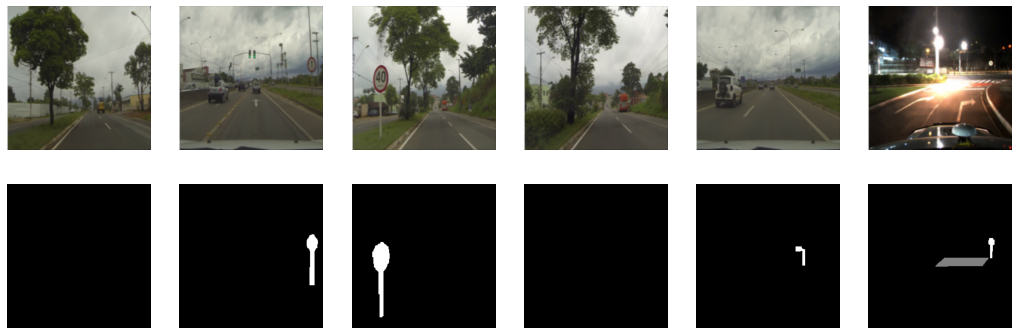

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    j = 100+10*i;
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[j])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[j].squeeze(), cmap='gray')
plt.show();

In [ ]:
print(j)

150


In [ ]:
unique, counts = np.unique(Y[150], return_counts=True)

result = np.column_stack((unique, counts))
print (result)

[[    0 64057]
 [    1  1251]
 [    2   228]]


In [ ]:
sum_by_image = np.sum(Y, (1, 2, 3))
print(sum_by_image.shape)

(3083,)


In [ ]:
unique, counts = np.unique(sum_by_image, return_counts=True)
result = np.column_stack((unique, counts))
print (result)

[[    0   461]
 [    8     1]
 [   32     1]
 ...
 [29420     1]
 [29790     1]
 [33807     1]]


In [ ]:
mask_indicies = np.where(sum_by_image > 100)

YY = np.array(sum_by_image > 100, dtype='uint8')
print(YY.shape)

(3083,)


In [ ]:
YY

array([0, 0, 0, ..., 1, 1, 1], dtype=uint8)

In [ ]:
print(YY[0:100])

[0 0 0 0 0 0 0 1 0 0 1 1 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 1 1 1 0 1 1 0 1 1 0 0 1 1 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 0 1 0 0]


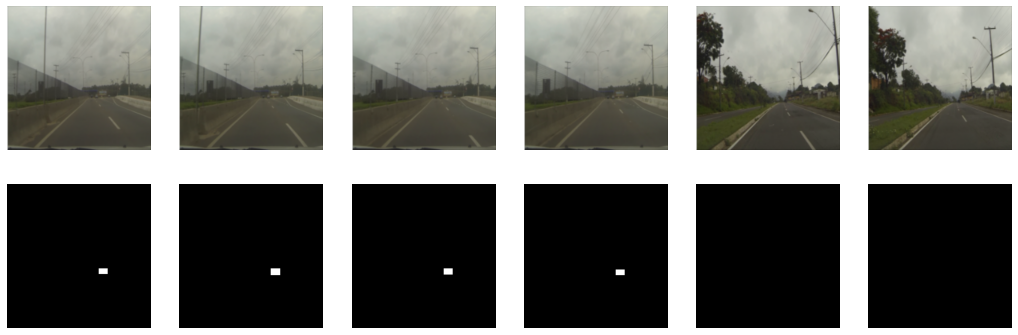

In [ ]:
plt.figure(figsize=(18, 6))
for i in range(6):
    j = 10 + i;
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[j])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[j].squeeze(), cmap='gray')
plt.show();

Let 3083 pictures by 2500/400/183 for traning, validation and test correspondingly.

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [2500, 2900])

In [ ]:
print(len(tr), len(val), len(ts))

2500 400 183


In [ ]:
DATA_MODES = ['train', 'val', 'test']

In [ ]:
print(len(YY))

3083


In [ ]:
X_train = X[tr]
X_val = X[val]
X_test = X[ts]

Y_train = YY[tr]
Y_val = YY[val]
Y_test = YY[ts]

X_train_t = torch.FloatTensor(X_train)
Y_train_t = torch.FloatTensor(Y_train)

X_val_t = torch.FloatTensor(X_val)
Y_val_t = torch.FloatTensor(Y_val)

X_test_t = torch.FloatTensor(X_test)
Y_test_t = torch.FloatTensor(Y_test)

train_dataset = TensorDataset(X_train_t, Y_train_t)
val_dataset = TensorDataset(X_val_t, Y_val_t)
test_dataset = TensorDataset(X_test_t, Y_test_t)

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [ ]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

# Классификация

In [ ]:
class SimpleCnn(nn.Module):
  
    def __init__(self, image_size, n_classes):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # => 128
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # => 64
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # => 32
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # => 16
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        ) # => 8

        self.size = int(image_size/32)
        self.fc_size = self.size*self.size*96
        
        self.out = nn.Sequential(
            nn.Linear(self.fc_size, 64),
            nn.ELU(),
            nn.Linear(64, 64),
            nn.ELU(),
            nn.Linear(64, n_classes)
        )
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = torch.reshape(x, (x.size(0), self.fc_size))
        
        logits = self.out(x)

        return logits.squeeze()

In [ ]:
def train(model, optimizer, loss_function, max_epochs = 10):
  losses = []

  for epoch in range(max_epochs):
      for it, (X_batch, y_batch) in enumerate(train_dataloader):
          X_batch = X_batch.permute(0,3,1,2).to(device)
          y_batch = y_batch.to(device)

          optimizer.zero_grad()

          outp = model(X_batch)

          loss = loss_function(outp, y_batch)

          loss.backward()

          optimizer.step()

          losses.append(loss.detach().cpu().flatten()[0])
          
          y_batch = y_batch.cpu()
          X_batch = X_batch.cpu()
          outp = outp.cpu() 

          probabilities = torch.sigmoid(outp)
          preds = (probabilities > 0.5).type(torch.long)

          batch_acc = (preds.flatten() == y_batch).type(torch.float32).sum() / y_batch.size(0)
          
          if (it + epoch * len(train_dataloader)) % 100 == 0:
              print(f"Iteration: {it + epoch * len(train_dataloader)}\nBatch accuracy: {batch_acc}")
  
  return losses

In [ ]:
simpleNN = SimpleCnn(256, 1).to(device)
loss_function = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(simpleNN.parameters(), lr=0.05)

In [ ]:
for x in simpleNN.parameters():
  print(x, x.device)
  break;

Parameter containing:
tensor([[[[ 0.1753, -0.1628,  0.1146],
          [ 0.0840, -0.1433, -0.0988],
          [ 0.0925, -0.1522, -0.0026]],

         [[ 0.0346,  0.1913, -0.0990],
          [-0.1867, -0.0594,  0.1242],
          [-0.0718, -0.1835,  0.1511]],

         [[ 0.1741, -0.0541, -0.1491],
          [-0.1551,  0.1079,  0.0532],
          [-0.0907,  0.0829, -0.1795]]],


        [[[ 0.1874, -0.1747,  0.0553],
          [-0.0547,  0.0334,  0.0203],
          [ 0.0050, -0.1915, -0.1243]],

         [[-0.0565, -0.1028, -0.1800],
          [ 0.0500, -0.1262, -0.0268],
          [-0.1434,  0.1116, -0.1829]],

         [[-0.1234, -0.1707,  0.0634],
          [-0.0816, -0.1040,  0.1620],
          [-0.1140, -0.1277, -0.0170]]],


        [[[-0.1858, -0.1884,  0.0014],
          [ 0.0524, -0.1060,  0.0979],
          [ 0.0536,  0.1003,  0.0889]],

         [[ 0.1749, -0.0442,  0.1802],
          [ 0.1313,  0.1150,  0.0219],
          [-0.0732,  0.1099,  0.0176]],

         [[-0.1162, -0

In [ ]:
losses = train(simpleNN, optimizer, loss_function)

Iteration: 0
Batch accuracy: 0.7890625
Iteration: 100
Batch accuracy: 0.875


In [ ]:
def plot_losses(losses):
  plt.figure(figsize=(12, 8))
  plt.plot(range(len(losses)), losses)
  plt.xlabel("Iteration")
  plt.ylabel("Loss")
  plt.show()

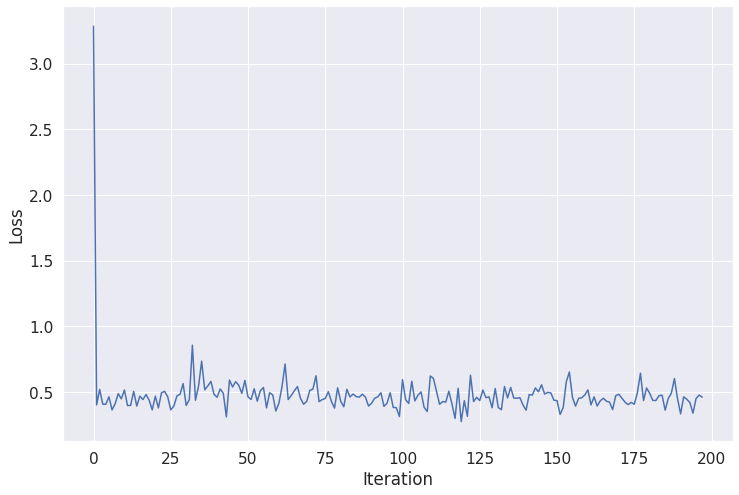

In [ ]:
plot_losses(losses[2:])

In [ ]:
@torch.no_grad()
def predict(dataloader, model):
    model.eval()
    predictions = np.array([])
    for x_batch, _ in dataloader:
        x_batch = x_batch.permute(0,3,1,2).to(device)
        lgts = model(x_batch)
        probs = torch.sigmoid(lgts)
        preds = (probs > 0.5).type(torch.long).cpu()
        predictions = np.hstack((predictions, preds.numpy().flatten()))
        x_batch = x_batch.cpu()
    return predictions.flatten()

In [ ]:
Y_pred_train = predict(train_dataloader, simpleNN)
accuracy_score(Y_train, Y_pred_train)

0.8424

In [ ]:
Y_pred = predict(val_dataloader, linear_regression)
accuracy_score(Y_val, Y_pred)